# **Першопочаткове налаштування**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

if tf.config.list_physical_devices('GPU'):
  print("TensorFlow IS using the GPU")
else:
  print("TensorFlow IS NOT using the GPU")

TensorFlow IS NOT using the GPU


Налаштування було успішним, у ході експериментів використовуватиметься GPU.

Перейдемо до реалізації практичного завдання лабораторної роботи, завантаживши класичний датасет для задачі класифікації зображень Fashion MNIST, що складається з зображень розміром 28*28 пікселів у сірому діапазоні кольорів.

Так як цей датасет вбудований в Keras, завантажимо його одразу:

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Завантажені зображення є, по суті, масивами пікселів, значення кожного з пікселів варіюється від 0 до 255, включно, а значення кожного з лейблів у масивах лейблів варіюються від 0 до 9 включно, ці значення є фактичними класами, до яких нейромережа приписуватиме зображення.

Так як ми хочемо отримати відносно точні результати у наслідку тренування нейромережі, одразу нормалізуємо формат даних таким чином, аби кожне значення використовуваних нейромережею масивів відповідало діапазону [0; 1].

Зробити це можна, поділивши значення масивів пікселів на 255, адже це є найбільшим значенням у масивах:

In [3]:
train_images = train_images / 255.0
test_images = test_images / 255.0

# **Побудова початкової моделі**

Побудуємо архітектуру простої секвентальної нейромережі (Sequential API):

In [4]:
model = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Дана модель матиме три слої:

1.  Вхідний слой Flatten, за рахунок пре-процесингу якого двомірні матриці пікселів перегортаються в одномірні масиви чисел, з якими зможе працювати нейромережа;
2.  Прихований слой Dense, який є основним обчислювальним слоєм з 128 нейронами, активаційна функція relu використовується через свою поширеність у простих задачах класифікації зображень;
3.  Вихідний слой Dense, має 10 нейронів для кожного з класів зображень ([0; 9]), активаційна функція softmax використовується для автоматичної конвертації вихідних даних у відсоткові значення для кожного з 10 класів.



# **Компіляція початкової моделі**

Проведемо компіляцію моделі та виведемо її архітектуру:

In [5]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        'accuracy',
        keras.losses.SparseCategoricalCrossentropy(name='xent')
        ]
)

У кожної мережі є три основні компіляційні параметри: функція оптимізації (optimizer), функція втрати (loss) і параметр виведення (metrics). Розглянемо вибір кожного з них:



*   Optimizer: було обрано Adam, адже ця функція є найбільш поширеною для задач класифікації;
*   Loss: було обрано Sparse Categorical Crossentropy, адже ця функція є найбільш поширеною для задач класифікації;
*   Metrics: було обрано accuracy, адже по ходу тестування ми бажаємо бачити саме точність моделі нейромережі.



Виведемо підсумки зкомпільованої моделі нейромережі:

In [6]:
model.summary()

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Як можемо побачити, у створеній моделі:


1.   На першому слої: 784 (28*28) вхідних параметри, і 0 вихідних, адже слой є виключно вхідним;
2.   На другому слої: 128 вхідних параметрів (за кількістю нейронів), і 100480 (784 * 128 + 128 зміщень за замовчуванням) вихідних параметрів;
3. На третьому слої: 10 вхідних параметрів (за кількістю нейронів), і 1290 (128 * 10 + 10 зміщень за замовчуванням) вихідних параметрів;



# **Тренування початкової моделі**

Виконаємо першопочаткове тренування моделі з 10 епохами, і виділенням 20% тренувальних даних (12000 з 60000) на валідацію, аби розміри даних для валідації (12000) та тестування (10000) були приблизно однаковими:

In [7]:
history = model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7713 - loss: 0.6593 - xent: 0.6593 - val_accuracy: 0.8442 - val_loss: 0.4323 - val_xent: 0.4323
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8560 - loss: 0.4004 - xent: 0.4004 - val_accuracy: 0.8658 - val_loss: 0.3798 - val_xent: 0.3798
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8754 - loss: 0.3470 - xent: 0.3470 - val_accuracy: 0.8720 - val_loss: 0.3663 - val_xent: 0.3663
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8828 - loss: 0.3173 - xent: 0.3173 - val_accuracy: 0.8661 - val_loss: 0.3639 - val_xent: 0.3639
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8876 - loss: 0.3056 - xent: 0.3056 - val_accuracy: 0.8819 - val_loss: 0.3319 - val_xent: 0.3319
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8928 - loss: 0.2893 - xent: 0.2893 - val_accuracy: 0.8496 - val_loss: 0.4184 - val_xent: 0.4184
Epoch 7/10
1500/1500 ━━━━━━

Тепер, виконаємо аналіз точності моделі на тестових даних:

In [8]:
print("--- Перевіряємо точність моделі на тестових даних ---")
test_loss, test_accuracy, test_xent = model.evaluate(test_images, test_labels, verbose=2)
print("Тестова точність:", test_accuracy)
print("Тестова помилка:", test_loss)
print("Тестова фактична помилка:", test_xent)

--- Перевіряємо точність моделі на тестових даних ---
313/313 - 1s - 2ms/step - accuracy: 0.8756 - loss: 0.3556 - xent: 0.3554
Тестова точність: 0.8755999803543091
Тестова помилка: 0.3556303083896637
Тестова фактична помилка: 0.35541555285453796


Виведемо на графіку результати тестувань, що покажуть ефективність моделі:

In [9]:
def display_results(history, model=None, title=None):
  name = (
        title
        or (getattr(model, 'name', None))
        or (getattr(getattr(history, 'model', None), 'name', None))
        or 'Модель'
      )

  history_dictionary = history.history
  accuracy = history_dictionary['accuracy']
  val_accuracy = history_dictionary['val_accuracy']
  loss = history_dictionary['loss']
  val_loss = history_dictionary['val_loss']
  epochs_range = range(1, len(accuracy) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  fig.suptitle(f'Модель: {name}', fontsize=14, y=1.03)

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, accuracy, 'o-', color='#1f77b4', label='Точність тренування')
  plt.plot(epochs_range, val_accuracy, '-', color='#ff7f0e', label='Точність валідації')
  plt.title('Точність тренування і валідації')
  plt.xlabel('Епохи')
  plt.ylabel('Точність')
  plt.ylim(0.5, 1.0)
  plt.legend()
  plt.grid(alpha=0.2)

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, 'o-', color='#1f77b4', label='Помилка тренування')
  plt.plot(epochs_range, val_loss, '-', color='#ff7f0e', label='Помилка валідації')
  plt.title('Помилка тренування і валідації')
  plt.xlabel('Епохи')
  plt.ylabel('Помилка')
  plt.ylim(0.0, 0.5)
  plt.legend()
  plt.grid(alpha=0.2)

  fig.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


In [10]:
def display_all_results(histories, value, miny=0.25, maxy=0.45, title='Порівняння', ylabel=None, epochs=30):
  plt.figure(figsize=(10, 6))
  for name, history in histories.items():
    plt.plot(history.history[value], label=name)

  plt.xlabel("Епохи")
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend()
  plt.grid(alpha=0.2)
  plt.xlim([0, epochs])
  plt.ylim([miny, maxy])
  plt.show()

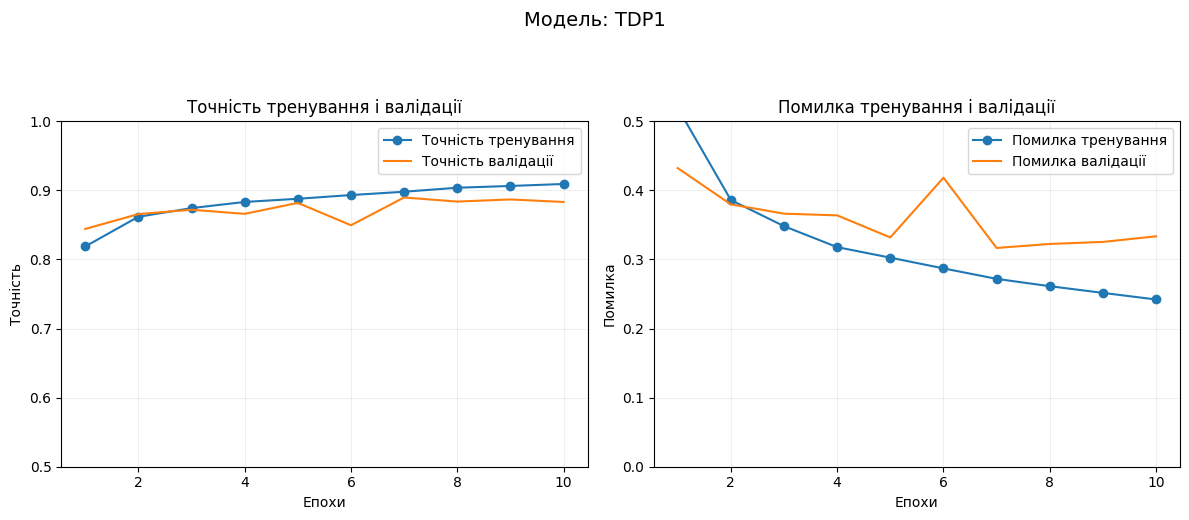

In [11]:
display_results(history)

Як можемо побачити, приблизно після 4 епох зменшується точність валідації даних, непропорційно тренувальним даним.

Спробуємо різні оптимізації, аби побачити їхній ефект на точності моделі, але спочатку збережемо першопочаткову модель:

In [12]:
model.save('tdp1_model_v1.keras')
print('\nЗбережено модель tdp1_model_v1')


Збережено модель tdp1_model_v1


# **Оптимізація місткості моделі**

Так як тестування виконуватимуться на відносно невеликому та збалансованому датасеті, звичайне використання системи збереження контрольних точок під час тренування не є обов'язковим.

Натомість, застосуємо цю систему для збереження найкращої моделі під час кожного індивідуального тренування, таким чином, навіть якщо тренування буде перерване, існуватиме модель, з якої можна буде відновити тренування, і наприкінці можна буде порівняти результати такої моделі з фактичними фінальними:

In [13]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='best_model_checkpoint.keras',
    monitor='val_xent',
    save_best_only=True,
    mode='min',
    verbose=1
)

Спочатку, аби запобігти перенавчання у будь-якому майбутньому сценаріЇ, застосуємо метод ранньої зупинки зі значенням толерантності 10:

In [14]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_xent',
    patience=10,
    min_delta=1e-3,
    restore_best_weights=True,
    mode='min'
)

Протестуємо раніше створену модель з новими гіперпараметрами, але спочатку визначимо загальні методи:

In [15]:
lr_reduction_callback = None;

In [16]:
def get_optimizer(lr=1e-3):
  return keras.optimizers.Adam(learning_rate=lr)

def get_lr_reduction_callback():
  return lr_reduction_callback

def compile_and_fit(model, name=None, optimizer=None, lr_callback=None, max_epochs=10000, batch_size=None):
  if optimizer is None:
    optimizer = get_optimizer()

  if lr_callback is None:
    lr_callback = get_lr_reduction_callback()
    if get_lr_reduction_callback() is None:
      callbacks = [early_stopping_callback, checkpoint_callback]
    else:
      lr_callback = get_lr_reduction_callback()
      callbacks = [early_stopping_callback, lr_callback, checkpoint_callback]
  else:
    callbacks = [early_stopping_callback, lr_callback, checkpoint_callback]

  model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
        keras.losses.SparseCategoricalCrossentropy(name='xent')
            ]
    )

  model.summary()

  history = model.fit(
      train_images,
      train_labels,
      epochs=max_epochs,
      batch_size=batch_size,
      validation_split=0.2,
      callbacks=callbacks,
      verbose=1
      )
  return history

Протестуємо найпопулярніші адаптивні методи навчання, щоб визначити найкращий. Наразі використовується метод Adam, спробуємо порівняти його ефективність з методами Adagrad, RMSProp, Adadelta:

In [17]:
initial_model = keras.models.load_model('tdp1_model_v1.keras')

optimizer_histories = {}
optimizer_histories['adam'] = compile_and_fit(initial_model, optimizer=keras.optimizers.Adam(), max_epochs=15)
optimizer_histories['adagrad'] = compile_and_fit(initial_model, optimizer=keras.optimizers.Adagrad(), max_epochs=15)
optimizer_histories['rmsprop'] = compile_and_fit(initial_model, optimizer=keras.optimizers.RMSprop(), max_epochs=15)
optimizer_histories['adadelta'] = compile_and_fit(initial_model, optimizer=keras.optimizers.Adadelta(), max_epochs=15)

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9112 - loss: 0.2311 - xent: 0.2311
Epoch 1: val_xent improved from inf to 0.33750, saving model to best_model_checkpoint.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9112 - loss: 0.2311 - xent: 0.2311 - val_accuracy: 0.8788 - val_loss: 0.3375 - val_xent: 0.3375
Epoch 2/15
1490/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9151 - loss: 0.2224 - xent: 0.2224
Epoch 2: val_xent improved from 0.33750 to 0.32167, saving model to best_model_checkpoint.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9151 - loss: 0.2225 - xent: 0.2225 - val_accuracy: 0.8889 - val_loss: 0.3217 - val_xent: 0.3217
Epoch 3/15
1488/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9202 - loss: 0.2149 - xent: 0.2149
Epoch 3: val_xent did not improve from 0.32167
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9202 - loss: 0.2150 - xent: 0.2150 - val_accuracy: 0.8867 - val_loss: 0.3340 - val_xent: 0.33

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9429 - loss: 0.1582 - xent: 0.1582
Epoch 1: val_xent improved from 0.31825 to 0.30597, saving model to best_model_checkpoint.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9429 - loss: 0.1582 - xent: 0.1582 - val_accuracy: 0.8972 - val_loss: 0.3060 - val_xent: 0.3060
Epoch 2/15
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9482 - loss: 0.1456 - xent: 0.1456
Epoch 2: val_xent improved from 0.30597 to 0.30430, saving model to best_model_checkpoint.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9481 - loss: 0.1456 - xent: 0.1456 - val_accuracy: 0.8987 - val_loss: 0.3043 - val_xent: 0.3043
Epoch 3/15
1492/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9495 - loss: 0.1425 - xent: 0.1425
Epoch 3: val_xent improved from 0.30430 to 0.30355, saving model to best_model_checkpoint.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9495 - loss: 0.1425 - xent: 0.1425 - val

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9347 - loss: 0.1787 - xent: 0.1787
Epoch 1: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9347 - loss: 0.1787 - xent: 0.1787 - val_accuracy: 0.8932 - val_loss: 0.3368 - val_xent: 0.3368
Epoch 2/15
1485/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9362 - loss: 0.1728 - xent: 0.1728
Epoch 2: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9362 - loss: 0.1728 - xent: 0.1728 - val_accuracy: 0.8919 - val_loss: 0.3564 - val_xent: 0.3564
Epoch 3/15
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9363 - loss: 0.1718 - xent: 0.1718
Epoch 3: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9363 - loss: 0.1718 - xent: 0.1718 - val_accuracy: 0.8827 - val_loss: 0.3910 - val_xent: 0.3910
Epoch 4/15
1491/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9383 - loss: 0.1681 - x

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9445 - loss: 0.1519 - xent: 0.1519
Epoch 1: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9445 - loss: 0.1519 - xent: 0.1519 - val_accuracy: 0.8944 - val_loss: 0.3343 - val_xent: 0.3343
Epoch 2/15
1493/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9438 - loss: 0.1508 - xent: 0.1508
Epoch 2: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9438 - loss: 0.1508 - xent: 0.1508 - val_accuracy: 0.8950 - val_loss: 0.3327 - val_xent: 0.3327
Epoch 3/15
1487/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9471 - loss: 0.1462 - xent: 0.1462
Epoch 3: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9471 - loss: 0.1462 - xent: 0.1462 - val_accuracy: 0.8957 - val_loss: 0.3313 - val_xent: 0.3313
Epoch 4/15
1487/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9470 - loss: 0.1446 - x

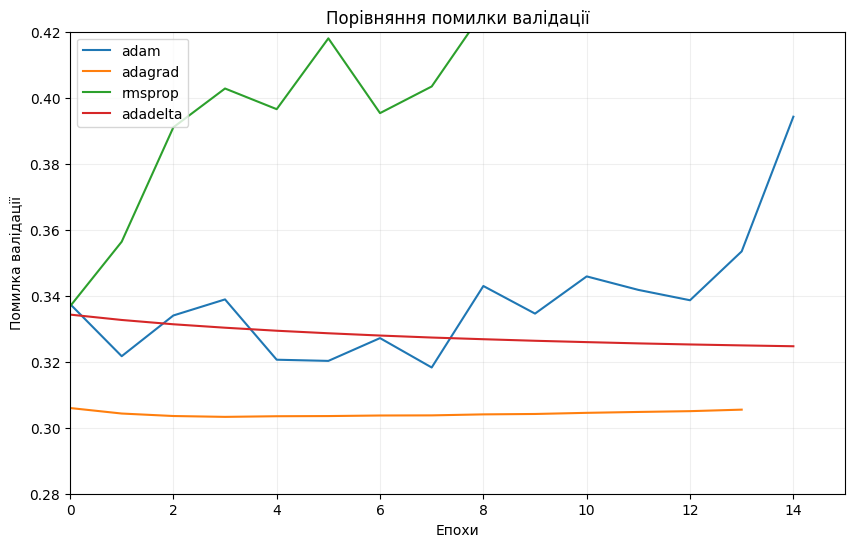

In [18]:
display_all_results(optimizer_histories, 'val_loss', miny=0.28, maxy=0.42, epochs=15, title='Порівняння помилки валідації', ylabel='Помилка валідації')

Як бачимо, метод Adam поступається приблизно на 1% помилки методу Adagrad, однак це викликано тим, що метод Adagrad, на відміну від методу Adam, використовує зниження швидкості навчання за замовчуванням. Вважатимемо таку малу різницю задовільною, і продовжимо з використанням методу Adam:

In [19]:
history = optimizer_histories['adam']

Протестуємо три різні конфігурації швидкості навчання, аби визначити, яка є найбільш оптимальною в нашому випадку.

Серед них:


*   Конфігурація 1 - середні зменшення, середня чутливість до покращень;
*   Конфігурація 2 - невеликі зменшення, низька чутливість до покращень;
*   Конфігурація 3 - сильні зменшення, висока чутливість до покращень.



In [20]:
lr_reduction_callback1 = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    cooldown=2,
    min_delta=1.5e-4,
    min_lr=5e-6,
    verbose=1,
    mode='min'
)

lr_reduction_callback2 = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    cooldown=2,
    min_delta=1e-3,
    min_lr=1e-6,
    verbose=1,
    mode='min'
)

lr_reduction_callback3 = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=6,
    cooldown=2,
    min_delta=5e-4,
    min_lr=1e-6,
    verbose=1,
    mode='min'
)

Застосуємо новостворені оптимізації на раніше збереженій моделі та виведемо результати порівняння всіх моделей:

In [21]:
initial_model = keras.models.load_model('tdp1_model_v1.keras')

lr_histories = {}
lr_histories['initial'] = history
lr_histories['lr1'] = compile_and_fit(initial_model, lr_callback=lr_reduction_callback1)
lr_histories['lr2'] = compile_and_fit(initial_model, lr_callback=lr_reduction_callback2)
lr_histories['lr3'] = compile_and_fit(initial_model, lr_callback=lr_reduction_callback3)

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1487/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9126 - loss: 0.2297 - xent: 0.2297
Epoch 1: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9126 - loss: 0.2297 - xent: 0.2297 - val_accuracy: 0.8865 - val_loss: 0.3184 - val_xent: 0.3184 - learning_rate: 0.0010
Epoch 2/10000
1483/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9143 - loss: 0.2223 - xent: 0.2223
Epoch 2: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9143 - loss: 0.2223 - xent: 0.2223 - val_accuracy: 0.8856 - val_loss: 0.3338 - val_xent: 0.3338 - learning_rate: 0.0010
Epoch 3/10000
1483/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9183 - loss: 0.2157 - xent: 0.2157
Epoch 3: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9183 - loss: 0.2157 - xent: 0.2157 - val_accuracy: 0.8878 - val_loss: 0.3165 - val_xent: 0.3165 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9291 - loss: 0.1878 - xent: 0.1878
Epoch 1: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9291 - loss: 0.1878 - xent: 0.1878 - val_accuracy: 0.8912 - val_loss: 0.3296 - val_xent: 0.3296 - learning_rate: 0.0010
Epoch 2/10000
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9349 - loss: 0.1763 - xent: 0.1763
Epoch 2: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9349 - loss: 0.1764 - xent: 0.1764 - val_accuracy: 0.8853 - val_loss: 0.3593 - val_xent: 0.3593 - learning_rate: 0.0010
Epoch 3/10000
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9340 - loss: 0.1771 - xent: 0.1771
Epoch 3: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9340 - loss: 0.1771 - xent: 0.1771 - val_accuracy: 0.8882 - val_loss: 0.3383 - val_xent: 0.3383 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1484/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9319 - loss: 0.1798 - xent: 0.1798
Epoch 1: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9319 - loss: 0.1798 - xent: 0.1798 - val_accuracy: 0.8942 - val_loss: 0.3394 - val_xent: 0.3394 - learning_rate: 0.0010
Epoch 2/10000
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9354 - loss: 0.1749 - xent: 0.1749
Epoch 2: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9354 - loss: 0.1749 - xent: 0.1749 - val_accuracy: 0.8877 - val_loss: 0.3606 - val_xent: 0.3606 - learning_rate: 0.0010
Epoch 3/10000
1483/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9362 - loss: 0.1722 - xent: 0.1722
Epoch 3: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9362 - loss: 0.1722 - xent: 0.1722 - val_accuracy: 0.8914 - val_loss: 0.3525 - val_xent: 0.3525 - learning_rate: 0.0010
Epoch 4/10

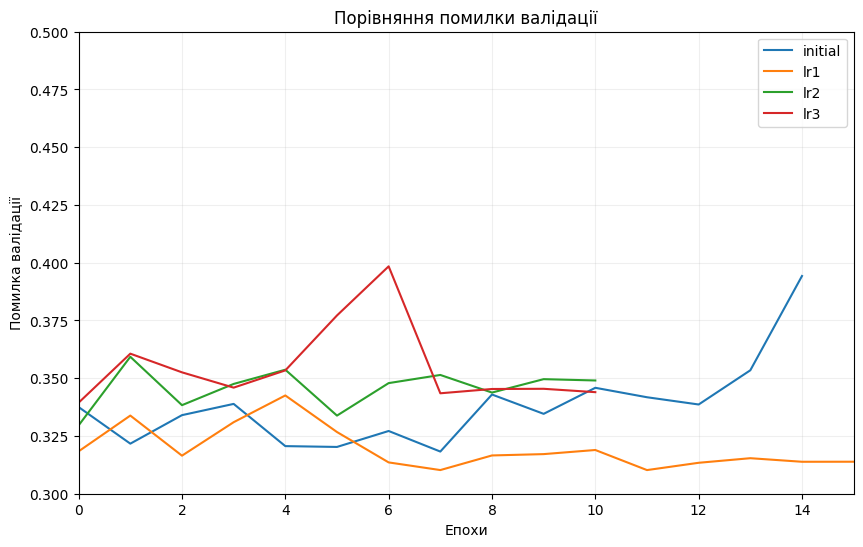

In [22]:
display_all_results(lr_histories, 'val_loss', miny=0.3, maxy=0.5, epochs=15, title='Порівняння помилки валідації', ylabel='Помилка валідації')

Як бачимо, результати другої конфігурації швидкості навчання є найкращими, що є логічним, адже вибірка даних є відносно рівномірно розподіленою на класи, та середньою за обсягом, і саме перший метод є найбільш стабільним - використовувати в подальшому ми будемо саме його.


Виведемо тепер результати тестування раніше збережної вибірки з щойно застосованими гіперпараметрами:

In [23]:
history = lr_histories['lr1']
lr_reduction_callback = lr_reduction_callback1

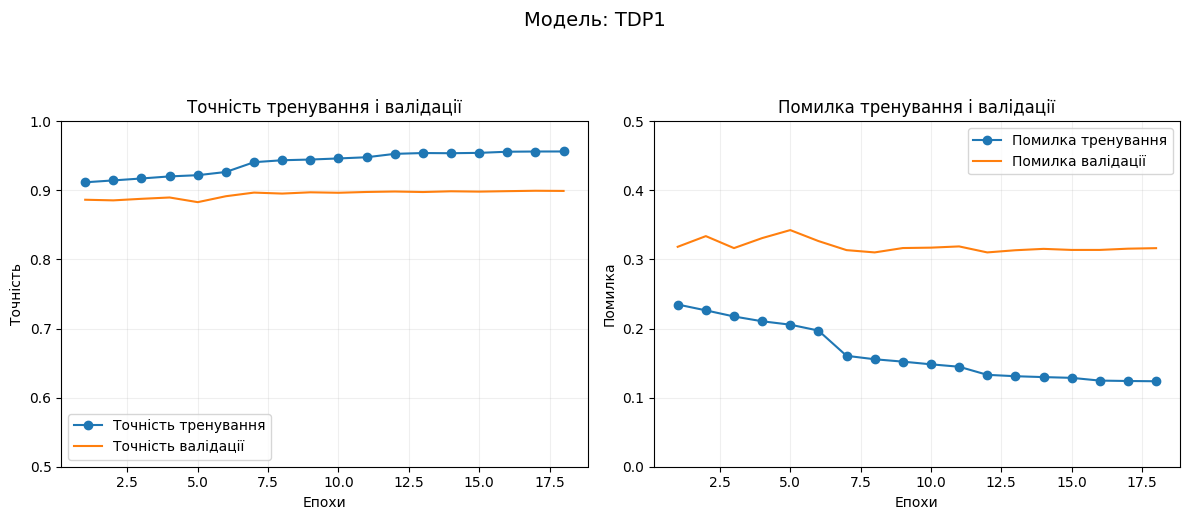

In [24]:
display_results(history)

Як можемо побачити, хоча запровадження зменшення швидкості навчання збільшило кількість епох з 10 до приблизно 25, результативна помилка на валідаційних даних краща.

Спробуємо тепер різні за розміром архітектури (кількість шарів та нейронів) з новоствореними пасивними оптимізаціями, аби визначити найбільш оптимальний розмір моделі. Визначимо початкові архітектури:

In [25]:
model_tiny = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_tiny'
)

model_small = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_small'
)

model_medium = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium'
)

model_large = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_large'
)

Проведемо компіляцію та тренування цих моделей:

In [26]:
size_histories = {}
size_histories['initial'] = history
size_histories['tiny'] = compile_and_fit(model_tiny)
size_histories['small'] = compile_and_fit(model_small)
size_histories['medium'] = compile_and_fit(model_medium)
size_histories['large'] = compile_and_fit(model_large)

Model: "TDP1_tiny"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,450 (99.41 KB)

 Trainable params: 25,450 (99.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1483/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7465 - loss: 0.7473 - xent: 0.7473
Epoch 1: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7472 - loss: 0.7452 - xent: 0.7452 - val_accuracy: 0.8292 - val_loss: 0.4942 - val_xent: 0.4942 - learning_rate: 0.0010
Epoch 2/10000
1482/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8469 - loss: 0.4364 - xent: 0.4364
Epoch 2: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8469 - loss: 0.4363 - xent: 0.4363 - val_accuracy: 0.8511 - val_loss: 0.4213 - val_xent: 0.4213 - learning_rate: 0.0010
Epoch 3/10000
1486/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8616 - loss: 0.3928 - xent: 0.3928
Epoch 3: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8616 - loss: 0.3928 - xent: 0.3928 - val_accuracy: 0.8608 - val_loss: 0.3936 - val_xent: 0.3936 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7617 - loss: 0.6958 - xent: 0.6958
Epoch 1: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7619 - loss: 0.6951 - xent: 0.6951 - val_accuracy: 0.8354 - val_loss: 0.4711 - val_xent: 0.4711 - learning_rate: 0.0010
Epoch 2/10000
1491/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8505 - loss: 0.4240 - xent: 0.4240
Epoch 2: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8505 - loss: 0.4239 - xent: 0.4239 - val_accuracy: 0.8644 - val_loss: 0.3866 - val_xent: 0.3866 - learning_rate: 0.0010
Epoch 3/10000
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8682 - loss: 0.3697 - xent: 0.3697
Epoch 3: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8682 - loss: 0.3697 - xent: 0.3697 - val_accuracy: 0.8637 - val_loss: 0.3801 - val_xent: 0.3801 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_medium"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7704 - loss: 0.6593 - xent: 0.6593
Epoch 1: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7706 - loss: 0.6588 - xent: 0.6588 - val_accuracy: 0.8598 - val_loss: 0.3928 - val_xent: 0.3928 - learning_rate: 0.0010
Epoch 2/10000
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8576 - loss: 0.3897 - xent: 0.3897
Epoch 2: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8576 - loss: 0.3896 - xent: 0.3896 - val_accuracy: 0.8689 - val_loss: 0.3696 - val_xent: 0.3696 - learning_rate: 0.0010
Epoch 3/10000
1482/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8742 - loss: 0.3422 - xent: 0.3422
Epoch 3: val_xent did not improve from 0.30329
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8743 - loss: 0.3421 - xent: 0.3421 - val_accuracy: 0.8475 - val_loss: 0.4168 - val_xent: 0.4168 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,762 (948.29 KB)

 Trainable params: 242,762 (948.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7695 - loss: 0.6566 - xent: 0.6566
Epoch 1: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7696 - loss: 0.6561 - xent: 0.6561 - val_accuracy: 0.8601 - val_loss: 0.3932 - val_xent: 0.3932 - learning_rate: 0.0010
Epoch 2/10000
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8607 - loss: 0.3785 - xent: 0.3785
Epoch 2: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8607 - loss: 0.3785 - xent: 0.3785 - val_accuracy: 0.8555 - val_loss: 0.4017 - val_xent: 0.4017 - learning_rate: 0.0010
Epoch 3/10000
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8740 - loss: 0.3368 - xent: 0.3368
Epoch 3: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8740 - loss: 0.3368 - xent: 0.3368 - val_accuracy: 0.8674 - val_loss: 0.3674 - val_xent: 0.3674 - learning_rate: 0.0010
Epoch 4/1

Виведемо результати на 4 графіки для кожної з моделей:

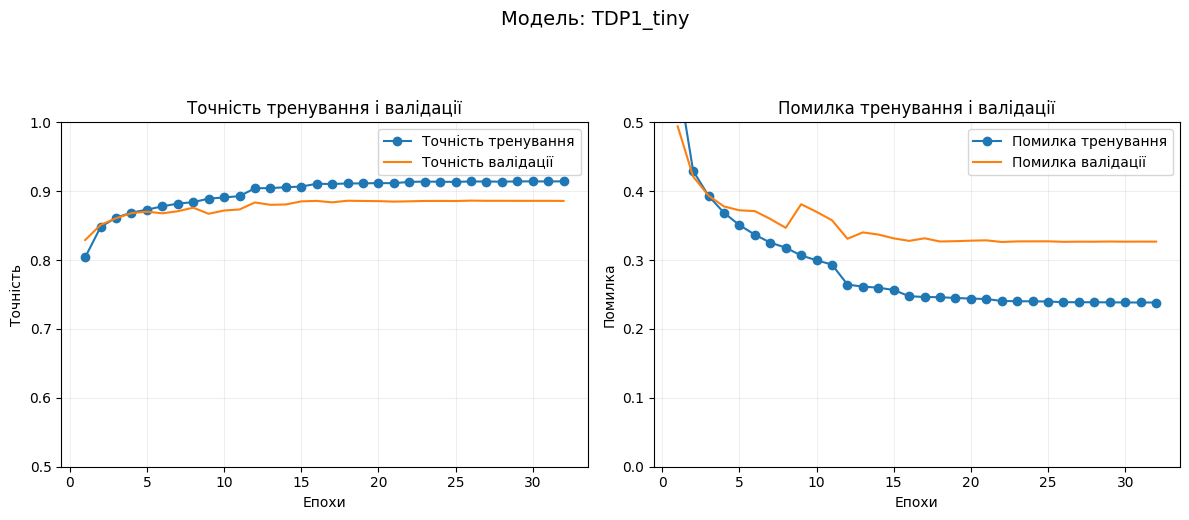

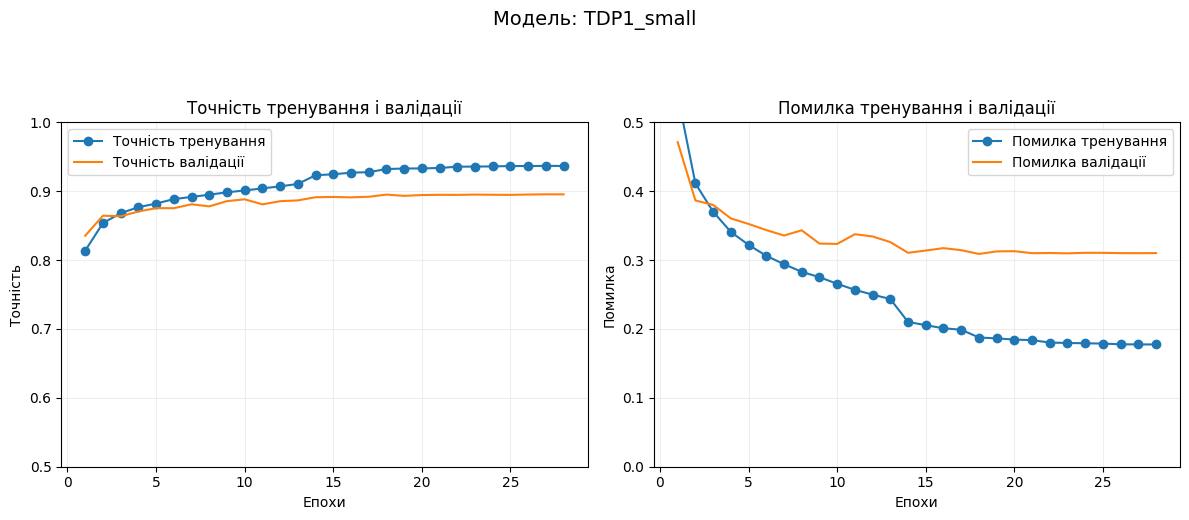

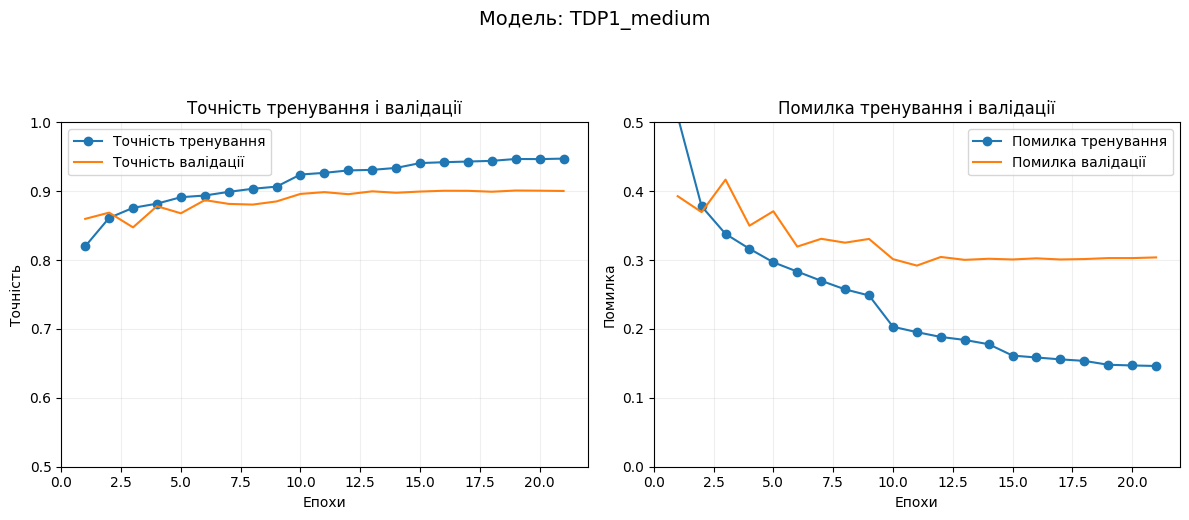

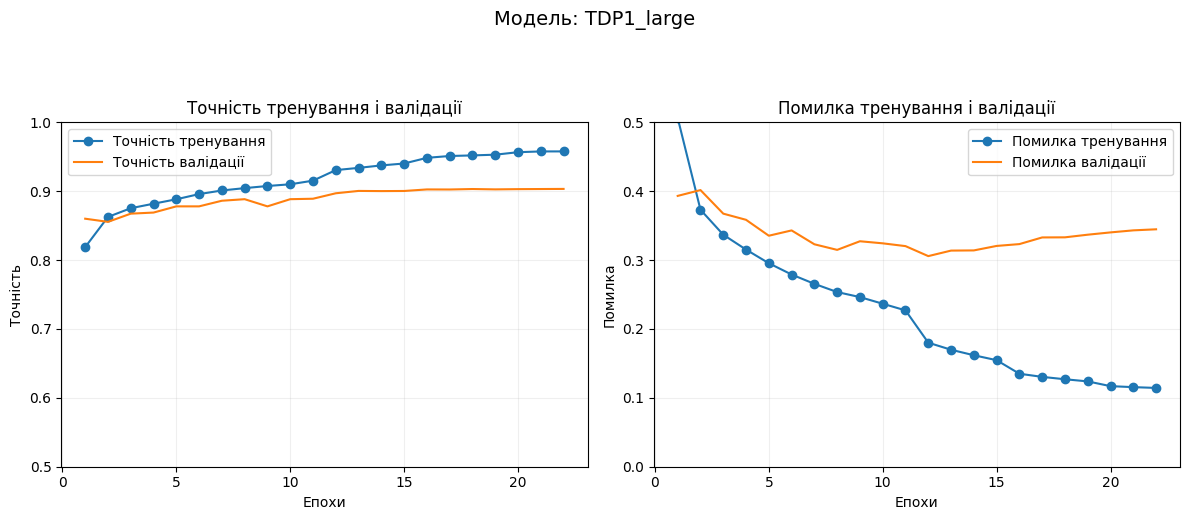

In [27]:
display_results(size_histories['tiny'])
display_results(size_histories['small'])
display_results(size_histories['medium'])
display_results(size_histories['large'])

Додатково, порівняємо на графіку результати помилки валідації всіх моделей, аби визначити найбільш підходящу для подальшої оптимізації архітектуру:

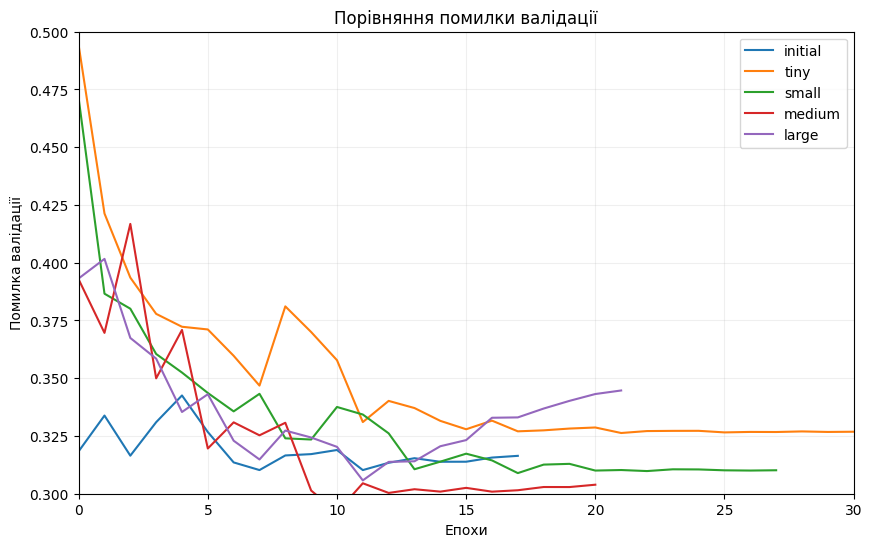

In [28]:
display_all_results(size_histories, 'val_loss', miny=0.3, maxy=0.5, title='Порівняння помилки валідації', ylabel='Помилка валідації')

Як можемо побачити, першопочаткова модель є занадто нестабільною через один прихований слой. Розглянемо інші моделі:


*   Крихітна модель - відбувається недонавчання, висока помилка на всіх епохах;
*   Мала модель - хороша помилка, однак ближче до 10 епох починаться перенавчання;
*   Середня модель - найнижча помилка протягом декількох епох, найбільш незначне перенавчання;
*   Велика модель - очевидне перенавчання;

Роблячи висновок із зображених на графіку результатів, найбільш підходящою моделлю для подальшого використання та оптимізації є середня модель. Мала модель є другим найкращим претендентом, і може буде використаною у ситуаціях де більш швидка модель є приорітетом точній моделі, але середня модель, в даному випадку, буде найбільш збалансованою, тож використаємо її.





Збережемо середню модель для подальших експериментів:

In [29]:
model_medium.save('tdp1_model_v2.keras')
print('\nЗбережено модель tdp1_model_v2')


Збережено модель tdp1_model_v2


# **Ліквідація перенавчання моделі**

Спробуємо застосувати подальші оптимізації, такі як L1/L2 регуляризації та Dropout, аби забезпечити ліквідацію перенавчання і подальше збільшення точності результатів.

Створимо дві моделі, що базуються на щойно збереженій середній моделі, кожна з яких застосуватиме різні види регуляризації: L1, L2 та L1 + L2:

In [30]:
model_medium_l1 = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1(1e-5)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1(1e-5)),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium_l1'
)

model_medium_l2 = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium_l2'
)

model_medium_l1l2 = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium_l1l2'
)

Виконаємо компіляцію та тестування нових моделей для порівняння результатів з оригіналом:

In [31]:
initial_model = keras.models.load_model('tdp1_model_v2.keras')

optimization_histories = {}
optimization_histories['initial'] = size_histories['medium']
optimization_histories['l1'] = compile_and_fit(model_medium_l1)
optimization_histories['l2'] = compile_and_fit(model_medium_l2)
optimization_histories['l1l2'] = compile_and_fit(model_medium_l1l2)

Model: "TDP1_medium_l1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7648 - loss: 0.7167 - xent: 0.6717
Epoch 1: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7649 - loss: 0.7165 - xent: 0.6715 - val_accuracy: 0.8136 - val_loss: 0.5431 - val_xent: 0.4977 - learning_rate: 0.0010
Epoch 2/10000
1487/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8562 - loss: 0.4386 - xent: 0.3927
Epoch 2: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8562 - loss: 0.4385 - xent: 0.3926 - val_accuracy: 0.8579 - val_loss: 0.4546 - val_xent: 0.4074 - learning_rate: 0.0010
Epoch 3/10000
1492/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8716 - loss: 0.3971 - xent: 0.3494
Epoch 3: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8716 - loss: 0.3971 - xent: 0.3494 - val_accuracy: 0.8399 - val_loss: 0.4851 - val_xent: 0.4359 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_medium_l2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7678 - loss: 0.6989 - xent: 0.6687
Epoch 1: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7679 - loss: 0.6985 - xent: 0.6682 - val_accuracy: 0.8483 - val_loss: 0.4619 - val_xent: 0.4287 - learning_rate: 0.0010
Epoch 2/10000
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8614 - loss: 0.4195 - xent: 0.3851
Epoch 2: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8614 - loss: 0.4195 - xent: 0.3851 - val_accuracy: 0.8487 - val_loss: 0.4418 - val_xent: 0.4043 - learning_rate: 0.0010
Epoch 3/10000
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8712 - loss: 0.3904 - xent: 0.3520
Epoch 3: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8712 - loss: 0.3904 - xent: 0.3520 - val_accuracy: 0.8688 - val_loss: 0.4054 - val_xent: 0.3645 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_medium_l1l2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7646 - loss: 0.7370 - xent: 0.6675
Epoch 1: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7648 - loss: 0.7363 - xent: 0.6669 - val_accuracy: 0.8552 - val_loss: 0.4806 - val_xent: 0.4138 - learning_rate: 0.0010
Epoch 2/10000
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8573 - loss: 0.4591 - xent: 0.3916
Epoch 2: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8573 - loss: 0.4591 - xent: 0.3916 - val_accuracy: 0.8658 - val_loss: 0.4446 - val_xent: 0.3750 - learning_rate: 0.0010
Epoch 3/10000
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8740 - loss: 0.4198 - xent: 0.3497
Epoch 3: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8740 - loss: 0.4198 - xent: 0.3497 - val_accuracy: 0.8533 - val_loss: 0.4794 - val_xent: 0.4081 - learning_rate: 0.0010
Epoch 4/10

Виведемо на 3 графіках результати для кожної з нових моделей:

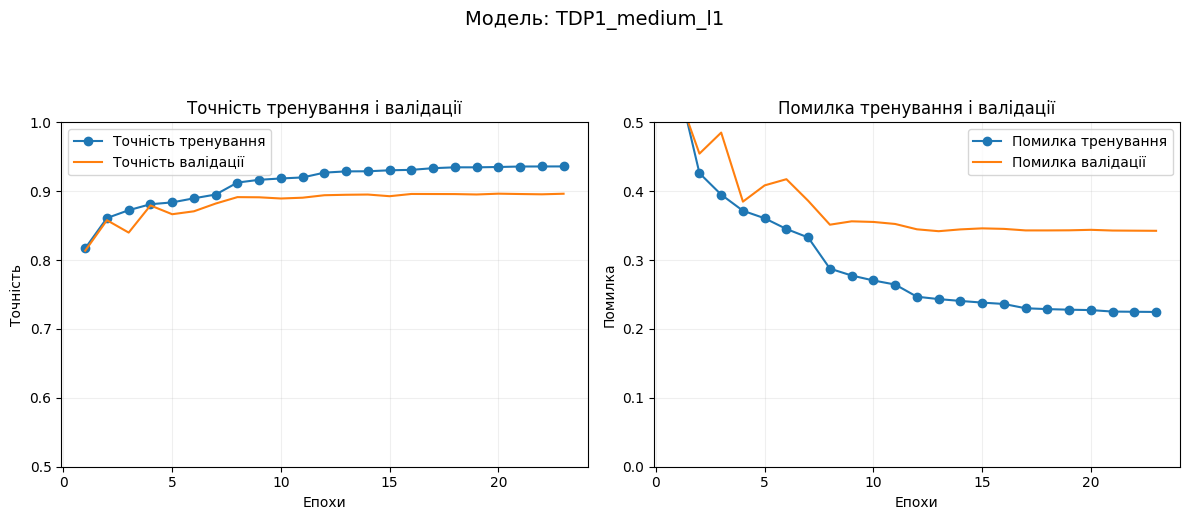

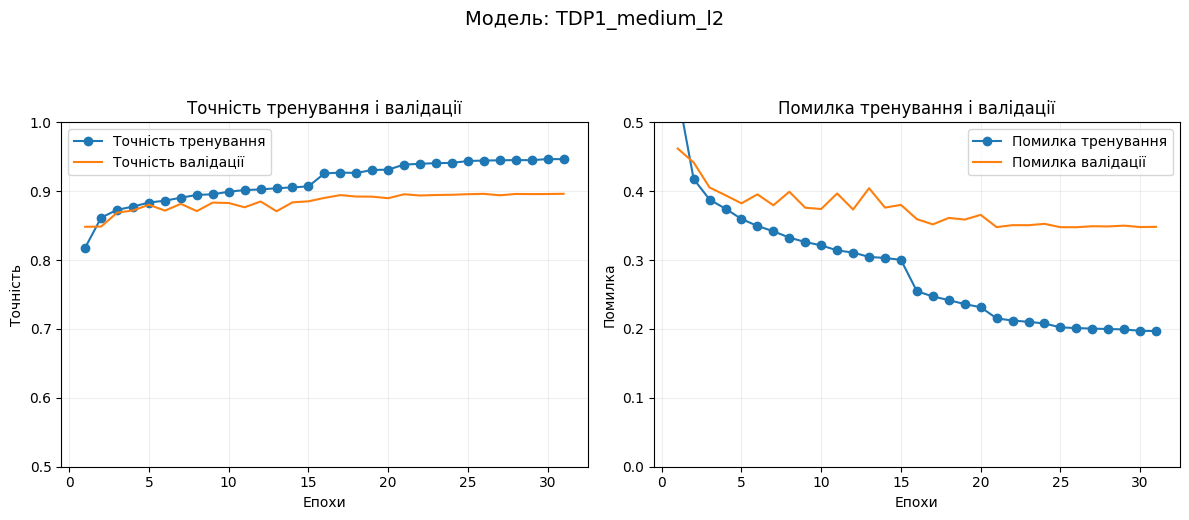

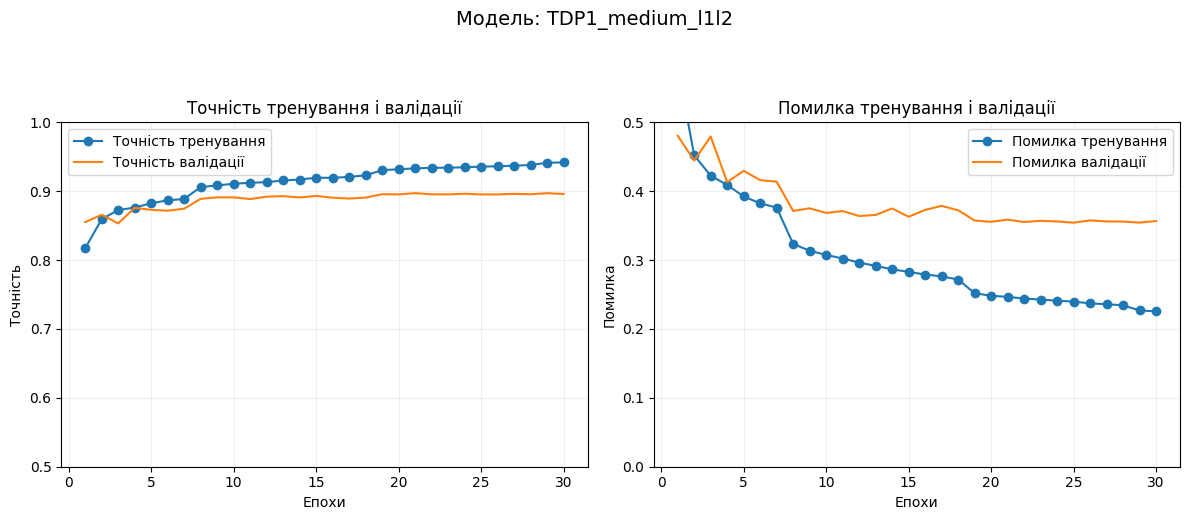

In [32]:
display_results(optimization_histories['l1'])
display_results(optimization_histories['l2'])
display_results(optimization_histories['l1l2'])

Виведемо результати фактичної помилки валідаційних даних всіх моделей для порівняння і визначення ефективності оптимізаційних методів, з урахуванням регуляризаційних штрафів:

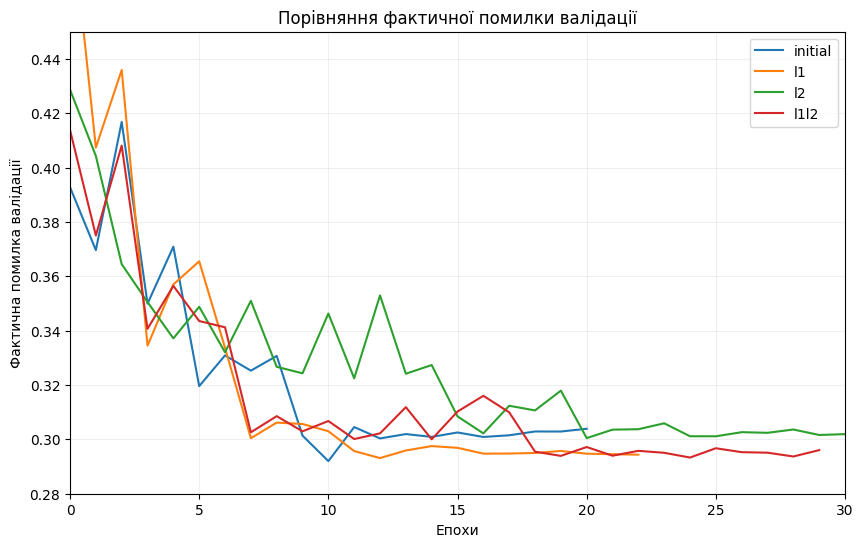

In [33]:
display_all_results(optimization_histories, 'val_xent', miny=0.28, title='Порівняння фактичної помилки валідації', ylabel='Фактична помилка валідації')

Для додаткової наглядності та остаточного рішення, виведемо точність валідаційних даних всіх моделей:

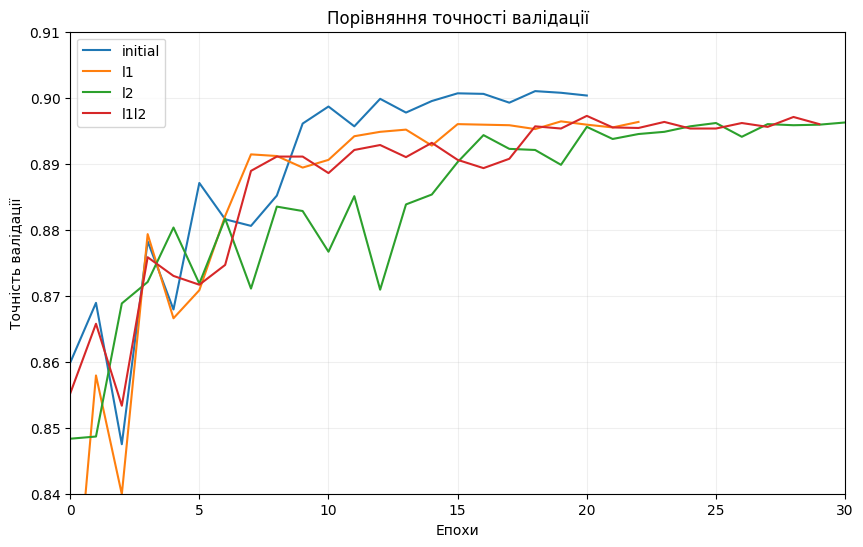

In [34]:
display_all_results(optimization_histories, 'val_accuracy', miny=0.84, maxy=0.91, title='Порівняння точності валідації', ylabel='Точність валідації')

Як результат тестувань, встановимо 0.00001, як значення параметрeа L1 та 0.0001, як значення параметра L2, вони є найбільш ідеальними для конкретно цієї тестової вибірки.

У висновку, можемо побачити, що:


*   Без регуляризації: нестабільна точність та перенавчання даними;
*   Регуляризація L1: ліквідація перенавчання, однак гірші результати за відсутність регуляризації та гірша стабільність;
*   Регуляризація L2: ліквідація перенавчання, кращі результати за відсутність регуляризації та найкраща стабільність;
*   Регуляризація L1 + L2: ліквідація перенавчання, кращі результати за відсутність регуляризації, але погані точність та стабільність.

Як результат, оберемо регуляризацію L2 і продовжимо оптимізацію.





Збережемо найкращу модель як основну:

In [35]:
model_medium_l2.save('tdp1_model_v3.keras')
print('\nЗбережено модель tdp1_model_v3')


Збережено модель tdp1_model_v3


Додамо Dropout як фінальний метод оптимізації. Створимо три нові моделі, аби знайти найбільш оптимальне значення Dropout - моделі міститимуть слої Dropout зі значеннями 0.2, 0.35 і 0.5, відповідно:

In [36]:
model_medium_l2_dropout02 = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium_l2_dropout0.2'
)

model_medium_l2_dropout035 = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.35),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.35),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium_l2_dropout0.35'
)

model_medium_l2_dropout05 = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
    ],
    name='TDP1_medium_l2_dropout0.5'
)

Виконаємо компіляцію та тестування нових моделей для визначення найкращого значення Dropout:

In [37]:
initial_model = keras.models.load_model('tdp1_model_v3.keras')

dropout_histories = {}
dropout_histories['initial'] = optimization_histories['l2']
dropout_histories['d0.2'] = compile_and_fit(model_medium_l2_dropout02)
dropout_histories['d0.35'] = compile_and_fit(model_medium_l2_dropout035)
dropout_histories['d0.5'] = compile_and_fit(model_medium_l2_dropout05)

Model: "TDP1_medium_l2_dropout0.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7120 - loss: 0.8792 - xent: 0.8056
Epoch 1: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7121 - loss: 0.8789 - xent: 0.8053 - val_accuracy: 0.8516 - val_loss: 0.4752 - val_xent: 0.4031 - learning_rate: 0.0010
Epoch 2/10000
1492/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8381 - loss: 0.5249 - xent: 0.4521
Epoch 2: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8381 - loss: 0.5248 - xent: 0.4520 - val_accuracy: 0.8624 - val_loss: 0.4516 - val_xent: 0.3766 - learning_rate: 0.0010
Epoch 3/10000
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8489 - loss: 0.4923 - xent: 0.4168
Epoch 3: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8489 - loss: 0.4922 - xent: 0.4168 - val_accuracy: 0.8567 - val_loss: 0.4666 - val_xent: 0.3891 - learning_rate: 0.0010
Epoch 4/1

Model: "TDP1_medium_l2_dropout0.35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1491/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6654 - loss: 1.0088 - xent: 0.9369
Epoch 1: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6660 - loss: 1.0072 - xent: 0.9354 - val_accuracy: 0.8377 - val_loss: 0.5246 - val_xent: 0.4537 - learning_rate: 0.0010
Epoch 2/10000
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8131 - loss: 0.5951 - xent: 0.5233
Epoch 2: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8131 - loss: 0.5951 - xent: 0.5233 - val_accuracy: 0.8478 - val_loss: 0.4939 - val_xent: 0.4192 - learning_rate: 0.0010
Epoch 3/10000
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8319 - loss: 0.5432 - xent: 0.4676
Epoch 3: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8319 - loss: 0.5432 - xent: 0.4676 - val_accuracy: 0.8493 - val_loss: 0.4742 - val_xent: 0.3958 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_medium_l2_dropout0.5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1492/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5987 - loss: 1.1927 - xent: 1.1222
Epoch 1: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5993 - loss: 1.1910 - xent: 1.1206 - val_accuracy: 0.8227 - val_loss: 0.5618 - val_xent: 0.4942 - learning_rate: 0.0010
Epoch 2/10000
1491/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7781 - loss: 0.6897 - xent: 0.6220
Epoch 2: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7781 - loss: 0.6896 - xent: 0.6219 - val_accuracy: 0.8357 - val_loss: 0.5128 - val_xent: 0.4439 - learning_rate: 0.0010
Epoch 3/10000
1493/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8019 - loss: 0.6386 - xent: 0.5687
Epoch 3: val_xent did not improve from 0.29200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8019 - loss: 0.6385 - xent: 0.5687 - val_accuracy: 0.8397 - val_loss: 0.5001 - val_xent: 0.4276 - learning_rate: 0.0010
Epoch 4/10

Виведемо на 3 різні графіки результати тестувань та валідації кожної з нових моделей:

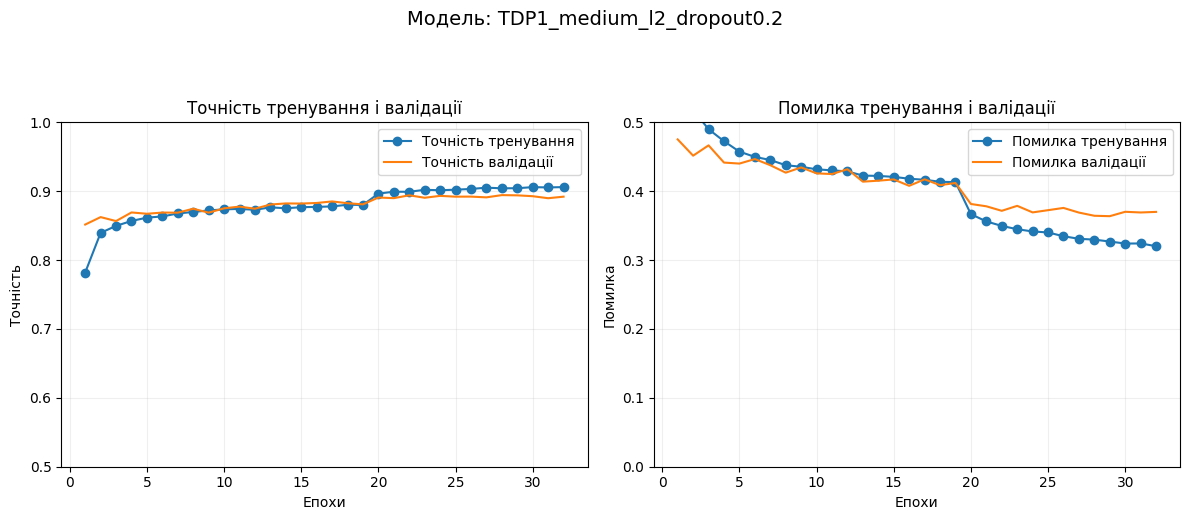

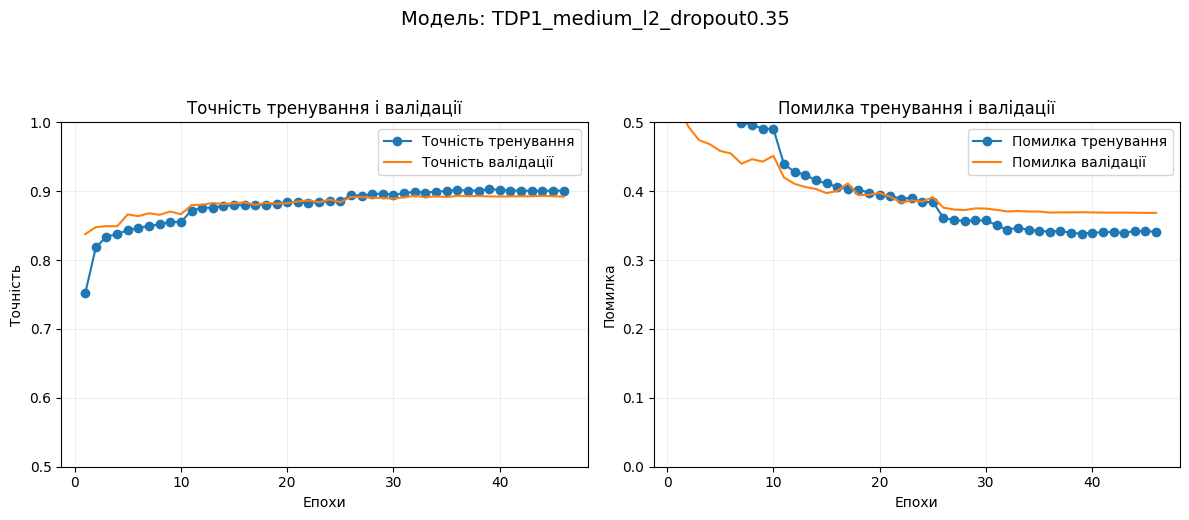

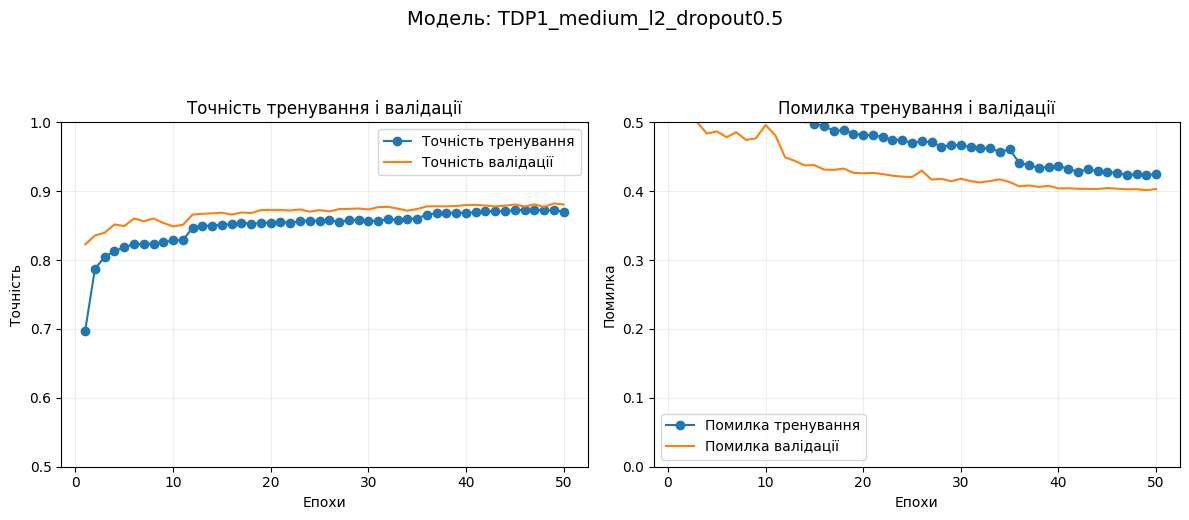

In [38]:
display_results(dropout_histories['d0.2'])
display_results(dropout_histories['d0.35'])
display_results(dropout_histories['d0.5'])

Виведемо результати фактичної помилки всіх моделей для порівняння ефективності різних значень Dropout на одному графіку:

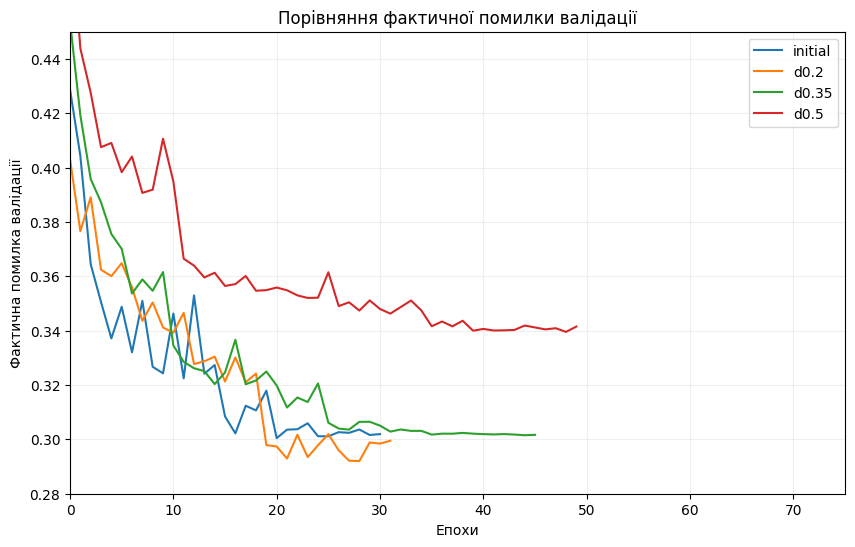

In [39]:
display_all_results(dropout_histories, 'val_xent', miny=0.28,
                    title='Порівняння фактичної помилки валідації', ylabel='Фактична помилка валідації',
                    epochs=75)

Можемо побачити, що найкращим серед обраних значень значенням Dropout є 0.2, тож застосуємо його і збережемо цю версію моделі:

In [40]:
model_medium_l2_dropout02.save('tdp1_model_v4.keras')
print('\nЗбережено модель tdp1_model_v4')


Збережено модель tdp1_model_v4


Нарешті, налаштуємо розмір батчу шляхом порівняння різних значень параметра:

In [41]:
initial_model = keras.models.load_model('tdp1_model_v4.keras')
model_b16 = initial_model
model_b32 = initial_model
model_b64 = initial_model
model_b128 = initial_model

batchsize_histories = {}
batchsize_histories['initial'] = dropout_histories['d0.2']
batchsize_histories['b16'] = compile_and_fit(model_b16, batch_size=16)
batchsize_histories['b32'] = compile_and_fit(model_b32, batch_size=32)
batchsize_histories['b64'] = compile_and_fit(model_b64, batch_size=64)
batchsize_histories['b128'] = compile_and_fit(model_b128, batch_size=128)

Model: "TDP1_medium_l2_dropout0.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
2997/3000 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8737 - loss: 0.4280 - xent: 0.3495
Epoch 1: val_xent did not improve from 0.29200
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8737 - loss: 0.4280 - xent: 0.3495 - val_accuracy: 0.8742 - val_loss: 0.4257 - val_xent: 0.3386 - learning_rate: 0.0010
Epoch 2/10000
2997/3000 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8698 - loss: 0.4363 - xent: 0.3479
Epoch 2: val_xent did not improve from 0.29200
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8698 - loss: 0.4363 - xent: 0.3479 - val_accuracy: 0.8671 - val_loss: 0.4523 - val_xent: 0.3596 - learning_rate: 0.0010
Epoch 3/10000
2994/3000 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8717 - loss: 0.4464 - xent: 0.3532
Epoch 3: val_xent did not improve from 0.29200
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8717 - loss: 0.4464 - xent: 0.3532 - val_accuracy: 0.8754 - val_loss: 0.4336 - val_xent: 0.3390 - learning_rate: 0.0010
Epoch 4

Model: "TDP1_medium_l2_dropout0.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8832 - loss: 0.3875 - xent: 0.3168
Epoch 1: val_xent did not improve from 0.28907
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8832 - loss: 0.3875 - xent: 0.3168 - val_accuracy: 0.8787 - val_loss: 0.4067 - val_xent: 0.3309 - learning_rate: 0.0010
Epoch 2/10000
1493/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8859 - loss: 0.3823 - xent: 0.3052
Epoch 2: val_xent did not improve from 0.28907
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8859 - loss: 0.3824 - xent: 0.3052 - val_accuracy: 0.8862 - val_loss: 0.4014 - val_xent: 0.3212 - learning_rate: 0.0010
Epoch 3/10000
1490/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8899 - loss: 0.3764 - xent: 0.2956
Epoch 3: val_xent did not improve from 0.28907
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8899 - loss: 0.3765 - xent: 0.2957 - val_accuracy: 0.8745 - val_loss: 0.4183 - val_xent: 0.3356 - learning_rate: 0.0010
Epoch 4/10

Model: "TDP1_medium_l2_dropout0.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8957 - loss: 0.3576 - xent: 0.2780
Epoch 1: val_xent did not improve from 0.28907
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8957 - loss: 0.3577 - xent: 0.2780 - val_accuracy: 0.8848 - val_loss: 0.3969 - val_xent: 0.3170 - learning_rate: 0.0010
Epoch 2/10000
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8939 - loss: 0.3654 - xent: 0.2854
Epoch 2: val_xent did not improve from 0.28907
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8938 - loss: 0.3654 - xent: 0.2854 - val_accuracy: 0.8873 - val_loss: 0.3959 - val_xent: 0.3149 - learning_rate: 0.0010
Epoch 3/10000
740/750 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8962 - loss: 0.3638 - xent: 0.2833
Epoch 3: val_xent did not improve from 0.28907
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8962 - loss: 0.3638 - xent: 0.2833 - val_accuracy: 0.8850 - val_loss: 0.4071 - val_xent: 0.3264 - learning_rate: 0.0010
Epoch 4/10000
740/750 

Model: "TDP1_medium_l2_dropout0.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
369/375 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9043 - loss: 0.3303 - xent: 0.2545
Epoch 1: val_xent did not improve from 0.28670
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9043 - loss: 0.3303 - xent: 0.2545 - val_accuracy: 0.8930 - val_loss: 0.3733 - val_xent: 0.2974 - learning_rate: 0.0010
Epoch 2/10000
370/375 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9058 - loss: 0.3293 - xent: 0.2536
Epoch 2: val_xent did not improve from 0.28670
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9058 - loss: 0.3294 - xent: 0.2536 - val_accuracy: 0.8912 - val_loss: 0.3778 - val_xent: 0.3018 - learning_rate: 0.0010
Epoch 3/10000
369/375 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9039 - loss: 0.3272 - xent: 0.2513
Epoch 3: val_xent did not improve from 0.28670
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9039 - loss: 0.3272 - xent: 0.2513 - val_accuracy: 0.8913 - val_loss: 0.3812 - val_xent: 0.3048 - learning_rate: 0.0010
Epoch 4/10000
374/375 

Виведемо результати валідаційних фактичної помилки та точності на два графіки:

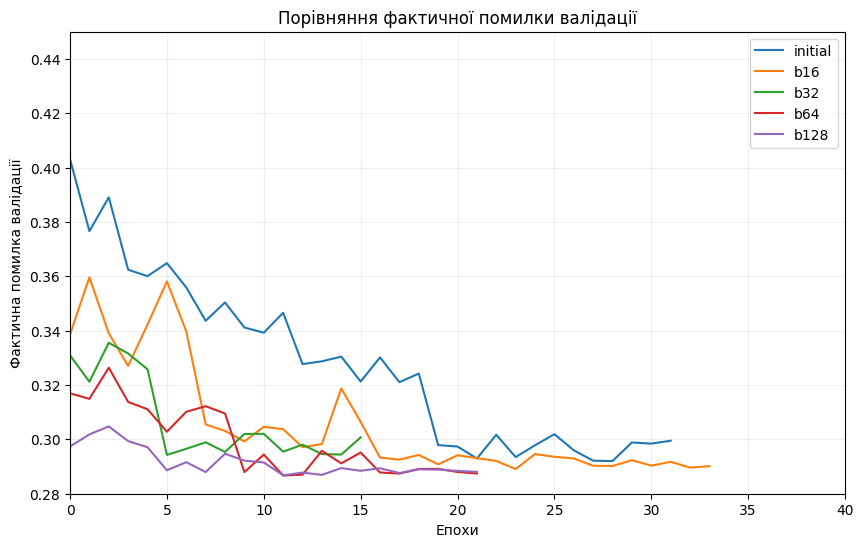

In [42]:
display_all_results(batchsize_histories, 'val_xent', miny=0.28,
                    title='Порівняння фактичної помилки валідації', ylabel='Фактична помилка валідації',
                    epochs=40)

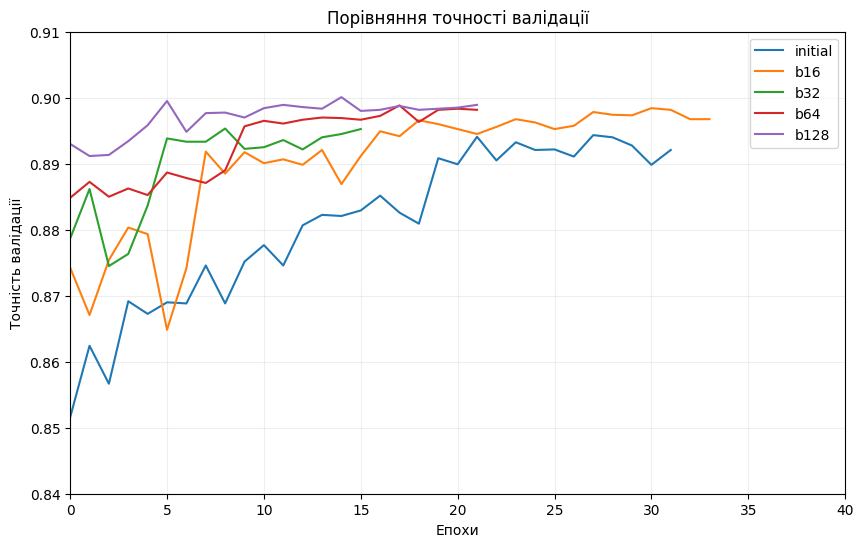

In [43]:
display_all_results(batchsize_histories, 'val_accuracy', miny=0.84, maxy=0.91,
                    title='Порівняння точності валідації', ylabel='Точність валідації',
                    epochs=40)

Як можемо побачити, розміри батчу в 16 і 32 мають значно кращі результати за розмір за замовчуванням, однак розмір батчу в 32 має кращу швидкість за нижчі розміри, тож оберемо саме його.

Так як архітектура моделі залишилася незмінною, збережемо лише нові гіперпараметри, окремо:

In [44]:
model_b32.save_weights('tdp1_model_v4.weights.h5')
print('\nЗбережено вагові коефіцієнти моделі tdp1_model_v4')


Збережено вагові коефіцієнти моделі tdp1_model_v4


Нарешті, протестуємо налаштовану та оптимізовану модель на реальних тестових даних:

In [45]:
final_model = keras.Sequential(
    [
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(10, activation='softmax')
    ]
)

final_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
        keras.losses.SparseCategoricalCrossentropy(name='xent')
            ]
    )

final_model.load_weights('tdp1_model_v4.weights.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [46]:
print("\n--- Перевіряємо точність фінальної моделі на тестових даних ---")

final_test_loss, final_test_accuracy, final_test_xent = final_model.evaluate(test_images, test_labels, verbose=2)

print("\nФінальна тестова точність:", final_test_accuracy)
print("Фінальна тестова помилка:", final_test_loss)


--- Перевіряємо точність фінальної моделі на тестових даних ---
313/313 - 2s - 5ms/step - accuracy: 0.8925 - loss: 0.3842 - xent: 0.3126

Фінальна тестова точність: 0.8924999833106995
Фінальна тестова помилка: 0.38423508405685425


In [47]:
best_checkpoint_model = keras.models.load_model('best_model_checkpoint.keras')

print("\n--- Перевіряємо точність збереженої контрольною точкою найкращої моделі на тестових даних ---")

checkpoint_test_loss, checkpoint_test_accuracy, checkpoint_test_xent = best_checkpoint_model.evaluate(test_images, test_labels, verbose=2)

print("\nТочність найкращої моделі з контрольної точки:", checkpoint_test_accuracy)
print("Помилка найкращої моделі з контрольної точки:", checkpoint_test_loss)


--- Перевіряємо точність збереженої контрольною точкою найкращої моделі на тестових даних ---
313/313 - 1s - 3ms/step - accuracy: 0.8896 - loss: 0.3883 - xent: 0.3108

Точність найкращої моделі з контрольної точки: 0.8895999789237976
Помилка найкращої моделі з контрольної точки: 0.38829222321510315


In [48]:
if final_test_xent <= checkpoint_test_xent:
    best_model_accuracy = final_test_accuracy
    best_model_xent = final_test_xent
    best_model_name = "фінальну модель"
else:
    best_model_accuracy = checkpoint_test_accuracy
    best_model_xent = checkpoint_test_xent
    best_model_name = "найкращу модель контрольної точки"

print(f"\nВибрано {best_model_name} для порівняння з початковою моделлю.")

accuracy_improvement = ((best_model_accuracy - test_accuracy) / test_accuracy) * 100
xent_reduction = ((test_xent - best_model_xent) / test_xent) * 100

print("Покращення тестової точності: {:.2f}%".format(accuracy_improvement))
print("Покращення фактичної тестової помилки: {:.2f}%".format(xent_reduction))


Вибрано найкращу модель контрольної точки для порівняння з початковою моделлю.
Покращення тестової точності: 1.60%
Покращення фактичної тестової помилки: 12.54%


Можемо побачити покращення результатів як точності, так і помилки моделі. Як наслідок, створено та оптимізовану просту модель для задачі класифікації рівномірно розподілених по класах зображень.